In [1]:
# importing necessary libraries
import numpy as np
import pandas as pd
import pymysql
from sqlite3 import dbapi2 as sq3
from pathlib import Path

import time
import copy
import random

from datetime import datetime
from dateutil import rrule

from io import BytesIO
from collections import OrderedDict
PATHSTART = '.'

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# function to connect to wiki_dbs and query
def connect_and_query(wiki_name, query, cnf_path = "/home/paws/.my.cnf"):
    
    conn = pymysql.connect(host = wiki_name + '.analytics.db.svc.wikimedia.cloud',
                           read_default_file = cnf_path,
                           database = wiki_name + '_p')
    
    with conn.cursor() as cur:
        cur.execute(query)
        data = cur.fetchall()
    
    conn.close()
    return data

In [4]:
query = """
SELECT 
    YEAR(STR_TO_DATE(r.rev_timestamp, '%Y%m%d%H%i%s')) AS edit_year, 
    COUNT(DISTINCT a.actor_user) AS active_editors  -- Count unique editors
FROM revision r
JOIN actor a ON r.rev_actor = a.actor_id  -- Link revisions to users
WHERE STR_TO_DATE(r.rev_timestamp, '%Y%m%d%H%i%s') >= DATE_SUB(NOW(), INTERVAL 1 YEAR)  -- Rolling YoY filter
GROUP BY edit_year
HAVING active_editors >= 1  -- Ensure at least 1 editor     
"""

output = connect_and_query('tewiki', query)

In [5]:

df = pd.DataFrame(output, columns=['edit_year', 'active_editors'])
df

,edit_year,active_editors
0,2024,886
1,2025,792


In [6]:
import matplotlib.pyplot as plt

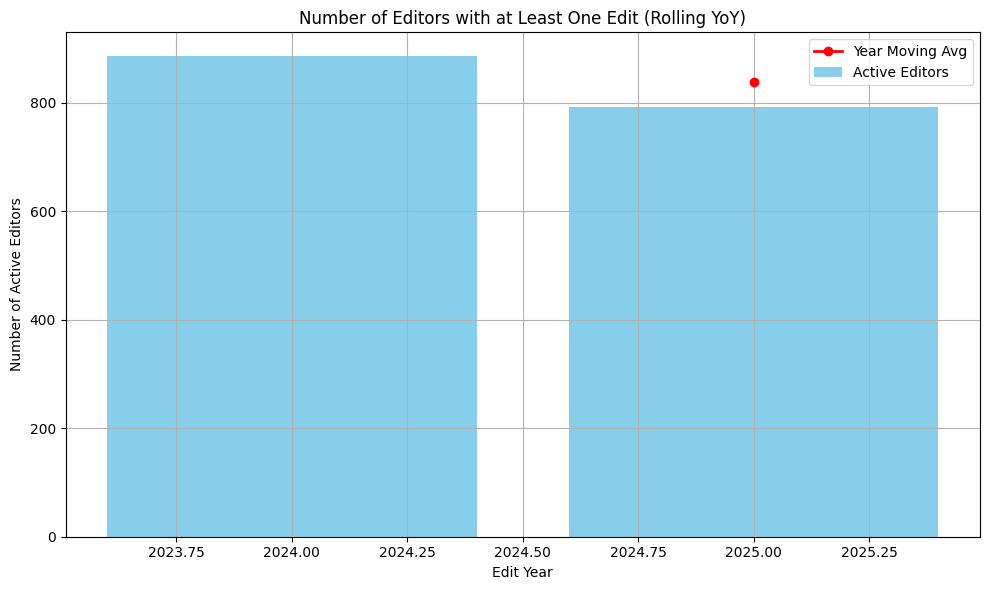

In [7]:
# Calculate 2-year moving average
df['moving_avg'] = df['active_editors'].rolling(window=2).mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(df['edit_year'], df['active_editors'], color='skyblue', label='Active Editors')
plt.plot(df['edit_year'], df['moving_avg'], color='red', marker='o', linestyle='-', linewidth=2, label='Year Moving Avg')

# Labels and title
plt.xlabel('Edit Year')
plt.ylabel('Number of Active Editors')
plt.title('Number of Editors with at Least One Edit (Rolling YoY)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()